In [1]:
import numpy as np
import cupy as cp
import pandas as pd
from hyperbolic_mf import HyperbolicMF, NegativeSampler
import matplotlib.pyplot as plt
from movie_utils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_path = '/app/datasets/movielens1m/'

# Load data

In [4]:
def load_movies_data(path, moviedata_name):
    dataframe = {'id': [], 'title': [], 'genres': []}
    with open(path + moviedata_name, 'r') as f:
        for line in f:
            ident, name, genres = line.split('::')
            dataframe['id'].append(int(ident))
            dataframe['title'].append(name)
            dataframe['genres'].append(genres.split('|'))
    return pd.DataFrame(dataframe)

def load_ratings_data(path, rating_name):
    dataframe = {'userid': [], 'movieid': [], 'rating': [], 'timestamp': []}
    with open(path + rating_name, 'r') as f:
        for line in f:
            userid, movieid, rating, timestamp = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['movieid'].append(int(movieid))
            dataframe['rating'].append(float(rating))
            dataframe['timestamp'].append(int(timestamp))
    return pd.DataFrame(dataframe)

def load_users_data(path, users_name):
    dataframe = {'userid': [], 'gender': [], 'age': [], 'occupation': [], 'zipcode': []}
    with open(path + users_name, 'r') as f:
        for line in f:
            userid, gender, age, occupation, zipcode = line.split('::')
            dataframe['userid'].append(int(userid))
            dataframe['gender'].append(0 if gennder == 'F' else 1)
            dataframe['age'].append(int(age))
            dataframe['occupation'].append(int(occupation))
            dataframe['zipcode'].append(int(zipcode))
    return pd.DataFrame(dataframe)

In [5]:
training_source = load_ratings_data(data_path, 'ratings.dat')
training_source

,userid,movieid,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
...,...,...,...,...
1000204,6040,1091,1.0,956716541
1000205,6040,1094,5.0,956704887
1000206,6040,562,5.0,956704746
1000207,6040,1096,4.0,956715648


# Preprocessing

In [6]:
train_val, test_val, hold_val = timepoint_split(training_source, time_split_q=0.9)
train_val, test_val, hold_val, data_index = transform_data(train_val, test_val, hold_val)

In [7]:
data_description = {
    'users': 'userid',
    'items': 'movieid',
    'feedback': 'rating',
    'n_users': len(data_index['users'].unique()),
    'n_items': len(data_index['items'].unique())
}
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 4831,
 'n_items': 3635}

In [8]:
hold_val['movieid'].isin(train_val['movieid']).sum() / len(hold_val['movieid'])

1.0

In [9]:
test_val['userid'].isin(train_val['userid']).sum() / len(test_val['userid'])

0.8405949024579462

# Hyperbolic MF full

In [11]:
np.random.seed(42)
cp.random.seed(42)

decomp_ranks = (np.arange(10) + 1) * 5

train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

results_HMF = []

for d in decomp_ranks:

    model = HyperbolicMF(sigma_U=0.1, sigma_V=0.1, backend=cp)
    losses, U_n, V_n = model.fit(train_interations, train_data, num_epochs=500, learning_rate=1e-6, decomposition_rank=d, batch_size=200)
    print('-' * 100)

    test_user_inds, U_norms = model.add_unknown_user(test_interations, test_data, n_iters=500, lr=1e-6, batch_size=200) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
    print(f'Dec rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')

    results_HMF.append((hr, mrr, cov, ndcg))

  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 5 	 HR@20: 0.0187 	 MRR@20: 0.0040 	 COV: 0.6787 	 NDCG@20: 0.0072


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 10 	 HR@20: 0.0526 	 MRR@20: 0.0090 	 COV: 0.4198 	 NDCG@20: 0.0182


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 15 	 HR@20: 0.0637 	 MRR@20: 0.0112 	 COV: 0.2856 	 NDCG@20: 0.0224


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 20 	 HR@20: 0.0637 	 MRR@20: 0.0135 	 COV: 0.2454 	 NDCG@20: 0.0240


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 25 	 HR@20: 0.0722 	 MRR@20: 0.0136 	 COV: 0.2094 	 NDCG@20: 0.0258


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 30 	 HR@20: 0.0637 	 MRR@20: 0.0138 	 COV: 0.1994 	 NDCG@20: 0.0243


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 35 	 HR@20: 0.0586 	 MRR@20: 0.0113 	 COV: 0.1928 	 NDCG@20: 0.0212


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 40 	 HR@20: 0.0620 	 MRR@20: 0.0102 	 COV: 0.1739 	 NDCG@20: 0.0211


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 45 	 HR@20: 0.0730 	 MRR@20: 0.0131 	 COV: 0.1689 	 NDCG@20: 0.0256


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
Dec rank: 50 	 HR@20: 0.0679 	 MRR@20: 0.0128 	 COV: 0.1615 	 NDCG@20: 0.0244


# SSVD

In [20]:
from scipy.sparse.linalg import svds

def rescale_matrix(matrix, scale_factor):
    freqs = matrix.getnnz(axis=0)
    mean_rating = matrix.sum(axis=1) / matrix.getnnz(axis=1).reshape((-1, 1))
    scaling_freqs = np.power(freqs, 0.5 * (scale_factor - 1))
    scaling_rating = np.power(mean_rating, 0.5 * (scale_factor - 1))
    return matrix.multiply(scaling_freqs).multiply(scaling_rating), (scaling_freqs, scaling_rating)

def build_ssvd_model(config, data, data_description, scale=True):
    _, source_matrix = generate_interactions_matrix(data, data_description, rebase_users=False)
    if scale:
        source_matrix, scale_weights = rescale_matrix(source_matrix, config['scaling'])
    _, _, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    # singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors#, scale_weights

def ssvd_scoring(item_factor_trunc, testset, data_description):
    _, matrix = generate_interactions_matrix(testset, data_description, rebase_users=True)
    scores = (matrix @ item_factor_trunc) @ item_factor_trunc.T
    downvote_seen_items(scores, testset, data_description)
    return scores

def ssvd_grid_search(ranks, scalings, training, testset, holdout, data_description, topn=20, scaled=True):
    max_rank = max(ranks)
    results = {}
    for scaling in scalings:
        # config = {'rank': max_rank, 'scaling': scaling}
        config = {'rank': max_rank, 'scaling': scaling}
        item_factors = build_ssvd_model(config, training, data_description)
        for rank in ranks:
            # config = {'rank': rank, 'scaling': scaling}
            item_factor_trunc = item_factors[:, :rank]
            scores = ssvd_scoring(item_factor_trunc, testset, data_description)
            recs = cp.argsort(scores)[:, -20:]#topn_recommendations(scores, topn-topn)
            results[(rank, scaling)] = model_evaluate(recs, holdout, data_description)
    return results

In [13]:
np.random.seed(42)
cp.random.seed(42)

results_SSVD = ssvd_grid_search(decomp_ranks, [0], train_val, test_val, hold_val, data_description, scaled=False)
# results_SSVD_s = ssvd_grid_search(decomp_ranks, [0], train_val, test_val, hold_val, data_description, scaled=True)

# Stochastic training of Hyperbolic MF

In [15]:
cp.random.seed(42)
np.random.seed(42)

# decomp_ranks = (np.arange(10) + 1) * 10
results_HMFs = []

for d in decomp_ranks:

    model = HyperbolicMF(sigma_U=0.1, sigma_V=0.1, backend=cp)
    sampler = NegativeSampler(train_val, data_description, neg_samples_multiplier=1, rebase_users=False)
    losses, U_n, V_n = model.fit_stochastic(sampler, num_iters=30000, learning_rate=1e-6, decomposition_rank=d, batch_size=2000)

    test_sampler = NegativeSampler(test_val, data_description, rebase_users=True)
    test_user_inds, U_norms = model.add_unknown_user_stochastic(test_sampler, n_iters=30000, lr=1e-6, batch_size=2000) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20)
    print(f'Dec rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV@20: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')
    results_HMFs.append((hr, mrr, cov, ndcg))

  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 5 	 HR@20: 0.0806 	 MRR@20: 0.0163 	 COV@20: 0.1051 	 NDCG@20: 0.0302


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 10 	 HR@20: 0.0832 	 MRR@20: 0.0090 	 COV@20: 0.1356 	 NDCG@20: 0.0241


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 15 	 HR@20: 0.1095 	 MRR@20: 0.0168 	 COV@20: 0.1296 	 NDCG@20: 0.0360


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 20 	 HR@20: 0.1036 	 MRR@20: 0.0225 	 COV@20: 0.1293 	 NDCG@20: 0.0393


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 25 	 HR@20: 0.0246 	 MRR@20: 0.0040 	 COV@20: 0.1301 	 NDCG@20: 0.0084


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 30 	 HR@20: 0.0968 	 MRR@20: 0.0113 	 COV@20: 0.1373 	 NDCG@20: 0.0286


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 35 	 HR@20: 0.0968 	 MRR@20: 0.0132 	 COV@20: 0.1309 	 NDCG@20: 0.0303


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 40 	 HR@20: 0.1027 	 MRR@20: 0.0135 	 COV@20: 0.1356 	 NDCG@20: 0.0317


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 45 	 HR@20: 0.0934 	 MRR@20: 0.0129 	 COV@20: 0.1331 	 NDCG@20: 0.0291


  0%|          | 0/30000 [00:00<?, ?it/s]

Dec rank: 50 	 HR@20: 0.0739 	 MRR@20: 0.0095 	 COV@20: 0.1373 	 NDCG@20: 0.0228


# Results

Text(0.5, 0, 'Decomposition rank')

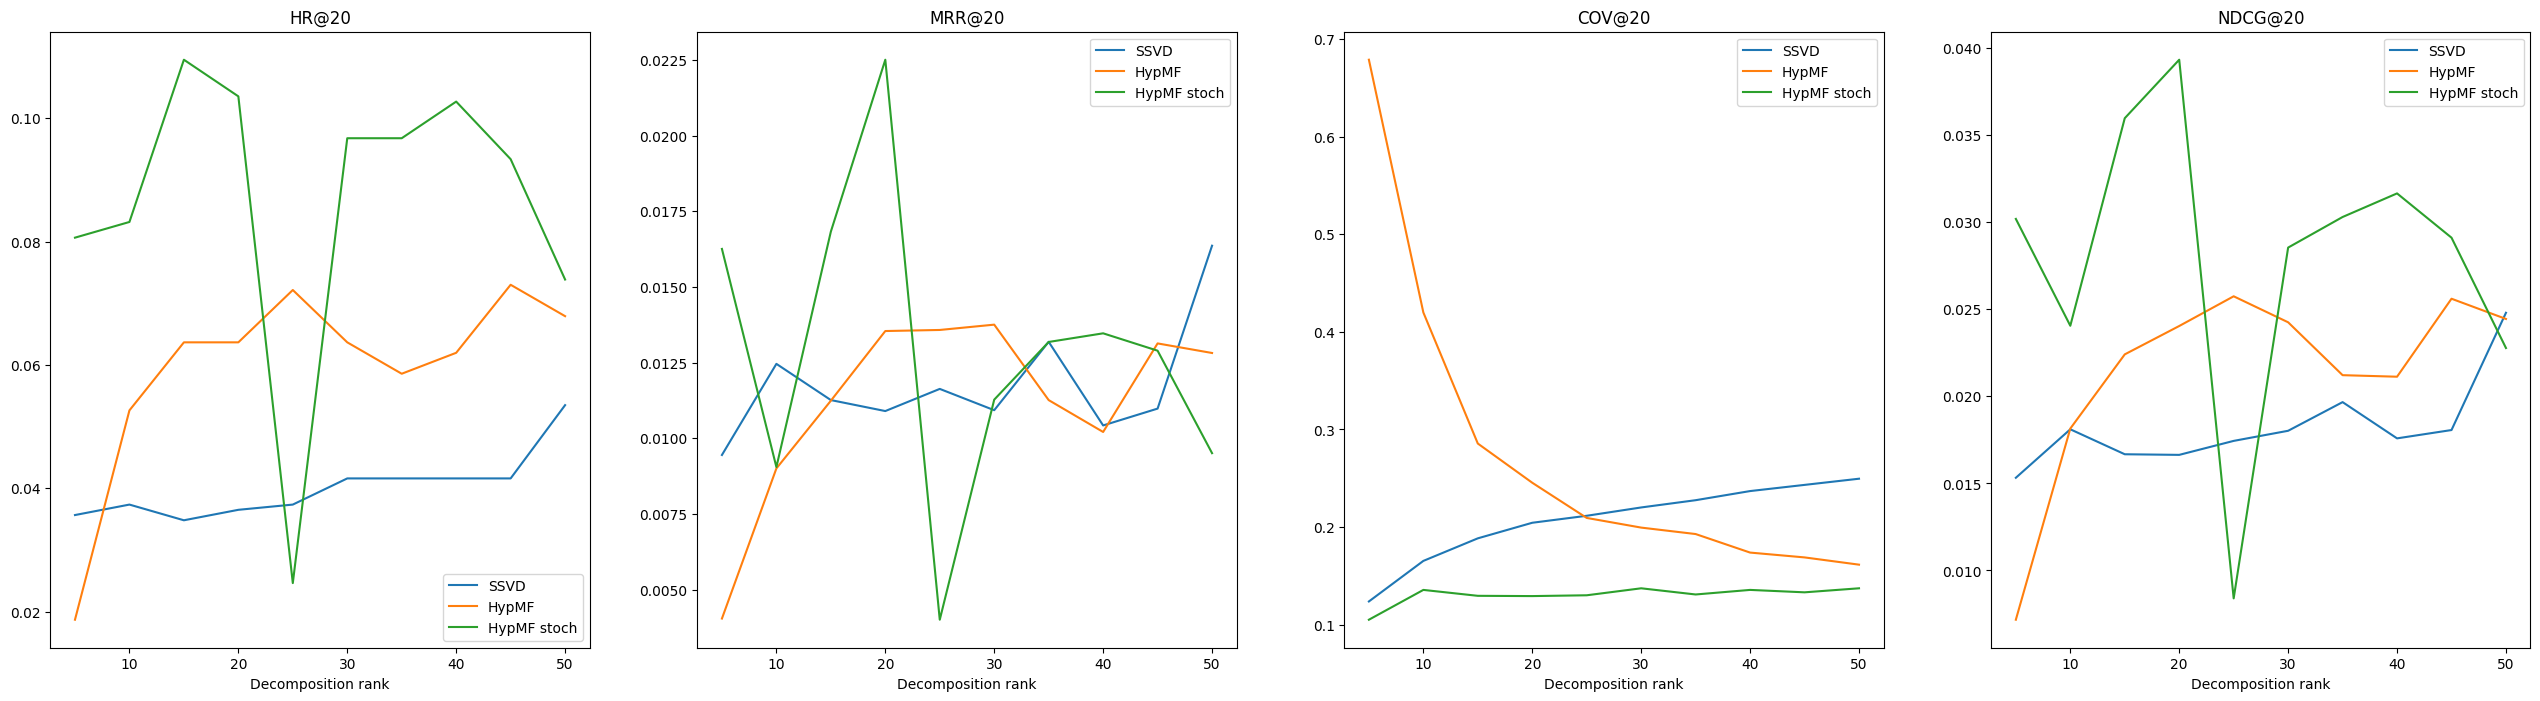

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(32, 8))
results_HMFs = np.array(results_HMFs)
results_HMF = np.array(results_HMF)
results_SSVD_r = np.array([results_SSVD[(i, 0)] for i in decomp_ranks])

axs[0].plot(decomp_ranks, results_SSVD_r[:, 0], label='SSVD')
axs[0].plot(decomp_ranks, results_HMF[:, 0], label='HypMF')
axs[0].plot(decomp_ranks, results_HMFs[:, 0], label='HypMF stoch')
# axs[0].plot(decomp_ranks, [results_ssvd[(i, 0)][0] for i in decomp_ranks], label='SSVD')
axs[0].set_title('HR@20')
axs[0].legend()
axs[0].set_xlabel('Decomposition rank')

axs[1].plot(decomp_ranks, results_SSVD_r[:, 1], label='SSVD')
axs[1].plot(decomp_ranks, results_HMF[:, 1], label='HypMF')
axs[1].plot(decomp_ranks, results_HMFs[:, 1], label='HypMF stoch')
# axs[1].plot(decomp_ranks, [results_ssvd[(i, 0)][1] for i in decomp_ranks], label='SSVD')
axs[1].set_title('MRR@20')
axs[1].legend()
axs[1].set_xlabel('Decomposition rank')

axs[2].plot(decomp_ranks, results_SSVD_r[:, 2], label='SSVD')
axs[2].plot(decomp_ranks, results_HMF[:, 2], label='HypMF')
axs[2].plot(decomp_ranks, results_HMFs[:, 2], label='HypMF stoch')
# axs[2].plot(decomp_ranks, [results_ssvd[(i, 0)][2] for i in decomp_ranks], label='SSVD')
axs[2].set_title('COV@20')
axs[2].legend()
axs[2].set_xlabel('Decomposition rank')

axs[3].plot(decomp_ranks, results_SSVD_r[:, 3], label='SSVD')
axs[3].plot(decomp_ranks, results_HMF[:, 3], label='HypMF')
axs[3].plot(decomp_ranks, results_HMFs[:, 3], label='HypMF stoch')
# axs[3].plot(decomp_ranks, [results_ssvd[(i, 0)][3] for i in decomp_ranks], label='SSVD')
axs[3].set_title('NDCG@20')
axs[3].legend()
axs[3].set_xlabel('Decomposition rank')

# Negative sampler tuning

In [17]:
# train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
# test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

cp.random.seed(42)
np.random.seed(42)

neg_ss = np.linspace(0.1, 1, 5)#.astype(np.int16)
res = []

for s in neg_ss:

    model = HyperbolicMF(sigma_U=0.1, sigma_V=0.1, backend=cp)
    sampler = NegativeSampler(train_val, data_description, neg_samples_multiplier=s, rebase_users=False)
    losses, U_n, V_n = model.fit_stochastic(sampler, num_iters=30000, learning_rate=1e-6, decomposition_rank=5, batch_size=2000)

    test_sampler = NegativeSampler(test_val, data_description, rebase_users=True)
    test_user_inds, U_norms = model.add_unknown_user_stochastic(test_sampler, n_iters=30000, lr=1e-6, batch_size=2000) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20)
    print(f'Neg mult: {s} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV@20: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')
    res.append((hr, mrr, cov, ndcg))

  0%|          | 0/30000 [00:00<?, ?it/s]

Neg mult: 0.1 	 HR@20: 0.0034 	 MRR@20: 0.0005 	 COV@20: 0.1012 	 NDCG@20: 0.0011


  0%|          | 0/30000 [00:00<?, ?it/s]

Neg mult: 0.325 	 HR@20: 0.0017 	 MRR@20: 0.0003 	 COV@20: 0.0880 	 NDCG@20: 0.0006


  0%|          | 0/30000 [00:00<?, ?it/s]

Neg mult: 0.55 	 HR@20: 0.0017 	 MRR@20: 0.0006 	 COV@20: 0.0762 	 NDCG@20: 0.0009


  0%|          | 0/30000 [00:00<?, ?it/s]

Neg mult: 0.775 	 HR@20: 0.0042 	 MRR@20: 0.0008 	 COV@20: 0.0740 	 NDCG@20: 0.0016


  0%|          | 0/30000 [00:00<?, ?it/s]

Neg mult: 1.0 	 HR@20: 0.0798 	 MRR@20: 0.0111 	 COV@20: 0.1186 	 NDCG@20: 0.0254


Text(0.5, 0, 'Negative samples multiplier')

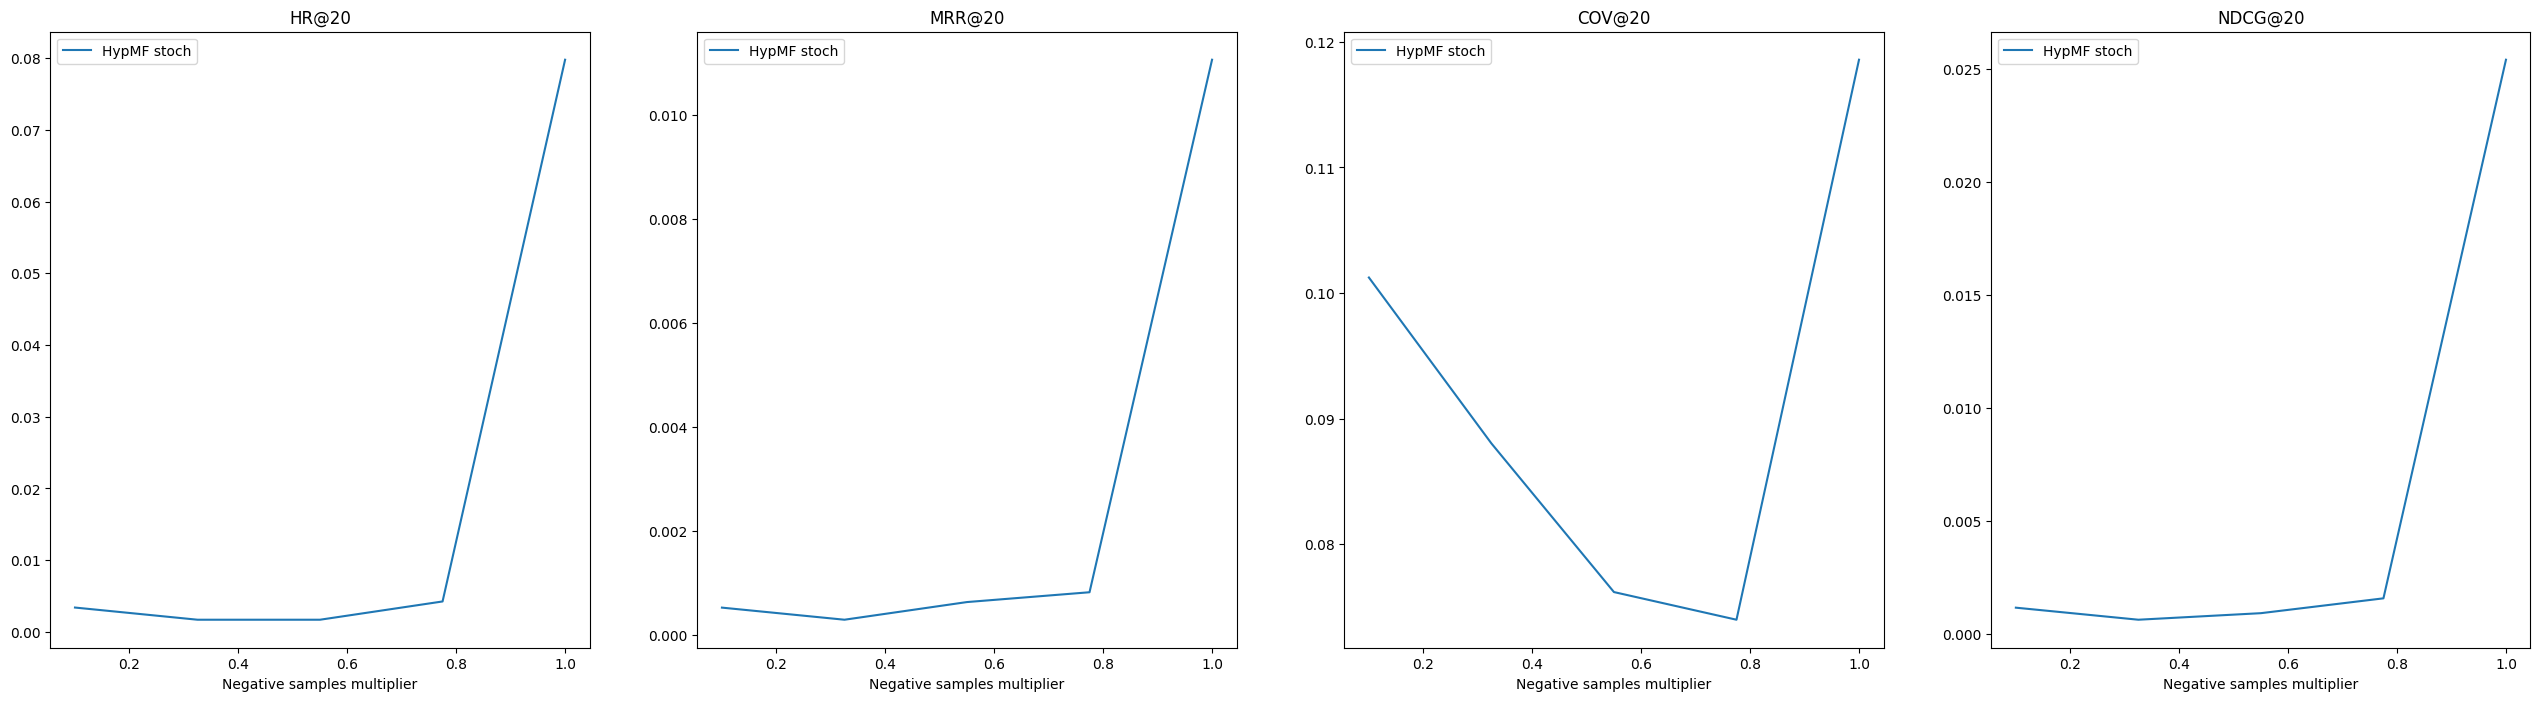

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(32, 8))
results = np.array(res)

axs[0].plot(neg_ss, results[:, 0], label='HypMF stoch')
# axs[0].plot(decomp_ranks, [results_ssvd[(i, 0)][0] for i in decomp_ranks], label='SSVD')
axs[0].set_title('HR@20')
axs[0].legend()
axs[0].set_xlabel('Negative samples multiplier')

axs[1].plot(neg_ss, results[:, 1], label='HypMF stoch')
# axs[1].plot(decomp_ranks, [results_ssvd[(i, 0)][1] for i in decomp_ranks], label='SSVD')
axs[1].set_title('MRR@20')
axs[1].legend()
axs[1].set_xlabel('Negative samples multiplier')

axs[2].plot(neg_ss, results[:, 2], label='HypMF stoch')
# axs[2].plot(decomp_ranks, [results_ssvd[(i, 0)][2] for i in decomp_ranks], label='SSVD')
axs[2].set_title('COV@20')
axs[2].legend()
axs[2].set_xlabel('Negative samples multiplier')

axs[3].plot(neg_ss, results[:, 3], label='HypMF stoch')
# axs[3].plot(decomp_ranks, [results_ssvd[(i, 0)][3] for i in decomp_ranks], label='SSVD')
axs[3].set_title('NDCG@20')
axs[3].legend()
axs[3].set_xlabel('Negative samples multiplier')